<a href="https://colab.research.google.com/github/shishir-sh26/port/blob/main/Deep_CNN%2CCRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep CNN**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import time

folder_path = '/content/drive/MyDrive/AvianWeatherNet/featuress/mel_spectrogram'
file_paths = []
labels = []

print("🔹 STEP 1: Scanning for .npy files...\n")
start_time = time.time()

for label_name in os.listdir(folder_path):
    label_folder = os.path.join(folder_path, label_name)
    if os.path.isdir(label_folder) and label_name.lower() != "unmapped":
        for file in os.listdir(label_folder):
            if file.endswith('.npy'):
                file_paths.append(os.path.join(label_folder, file))
                labels.append(label_name)

total_files = len(file_paths)
print(f"✅ Found {total_files} files in {round(time.time() - start_time, 2)} seconds.")


🔹 STEP 1: Scanning for .npy files...

✅ Found 18465 files in 46.05 seconds.


In [ ]:
import numpy as np
import cv2
import time

X = []
y = []

print("\n🔹 STEP 2: Loading and resizing Mel spectrograms...\n")

start_time = time.time()
total_files = len(file_paths)

# Set print update interval (every ~1% of total)
update_every = max(1, total_files // 100)

for idx, (path, label) in enumerate(zip(file_paths, labels)):
    try:
        mel = np.load(path)
        mel_resized = cv2.resize(mel, (128, 128), interpolation=cv2.INTER_AREA)
        X.append(mel_resized)
        y.append(label)
    except:
        continue

    if (idx + 1) % update_every == 0 or (idx + 1) == total_files:
        percent_done = ((idx + 1) / total_files) * 100
        elapsed = time.time() - start_time
        est_total = (elapsed / (idx + 1)) * total_files
        est_remain = est_total - elapsed

        print(f"✅ {idx + 1}/{total_files} files loaded "
              f"({percent_done:.2f}%) | Elapsed: {int(elapsed)}s | "
              f"ETA: ~{int(est_remain)}s")

# Convert lists to numpy arrays
X = np.array(X).astype('float32')
y = np.array(y)

print(f"\n✅ Loaded {len(X)} samples in {round(time.time() - start_time, 2)} seconds.")



🔹 STEP 2: Loading and resizing Mel spectrograms...

✅ 184/18465 files loaded (1.00%) | Elapsed: 482s | ETA: ~47904s
✅ 368/18465 files loaded (1.99%) | Elapsed: 485s | ETA: ~23881s
✅ 552/18465 files loaded (2.99%) | Elapsed: 488s | ETA: ~15859s
✅ 736/18465 files loaded (3.99%) | Elapsed: 492s | ETA: ~11871s
✅ 920/18465 files loaded (4.98%) | Elapsed: 495s | ETA: ~9452s
✅ 1104/18465 files loaded (5.98%) | Elapsed: 497s | ETA: ~7830s
✅ 1288/18465 files loaded (6.98%) | Elapsed: 501s | ETA: ~6687s
✅ 1472/18465 files loaded (7.97%) | Elapsed: 504s | ETA: ~5827s
✅ 1656/18465 files loaded (8.97%) | Elapsed: 509s | ETA: ~5168s
✅ 1840/18465 files loaded (9.96%) | Elapsed: 517s | ETA: ~4678s
✅ 2024/18465 files loaded (10.96%) | Elapsed: 522s | ETA: ~4241s
✅ 2208/18465 files loaded (11.96%) | Elapsed: 527s | ETA: ~3881s
✅ 2392/18465 files loaded (12.95%) | Elapsed: 534s | ETA: ~3588s
✅ 2576/18465 files loaded (13.95%) | Elapsed: 538s | ETA: ~3324s
✅ 2760/18465 files loaded (14.95%) | Elapsed: 54

In [ ]:
print("\n🔹 STEP 3: Normalizing Mel spectrograms...")

import time
start = time.time()

# Normalize each sample individually to avoid divide-by-zero
X_max = np.max(X, axis=(1, 2), keepdims=True) + 1e-8
X = X / X_max

# Add a channel dimension for CNN input (shape becomes: [batch, 128, 128, 1])
X = X[..., np.newaxis]

print(f"✅ Normalization complete in {round(time.time() - start, 2)} seconds.")



🔹 STEP 3: Normalizing Mel spectrograms...
✅ Normalization complete in 0.83 seconds.


In [ ]:
print("\n🔹 STEP 4: Encoding labels...")

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

print(f"✅ Labels encoded. Classes found: {list(le.classes_)}")



🔹 STEP 4: Encoding labels...
✅ Labels encoded. Classes found: [np.str_('Cloudy'), np.str_('Foggy'), np.str_('Rainy'), np.str_('Sunny'), np.str_('Windy')]


In [ ]:
print("\n🔹 STEP 5: Splitting into training and testing sets...")

from sklearn.model_selection import train_test_split
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print(f"✅ Split done in {round(time.time() - start, 2)} seconds.")
print(f"🔹 Training samples: {X_train.shape[0]}")
print(f"🔹 Testing samples: {X_test.shape[0]}")



🔹 STEP 5: Splitting into training and testing sets...
✅ Split done in 2.43 seconds.
🔹 Training samples: 14772
🔹 Testing samples: 3693


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

print("\n🔹 Building Deep CNN...")

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



🔹 Building Deep CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,637 (24.86 MB)

 Trainable params: 6,517,189 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tqdm.keras import TqdmCallback
import time

print("\n🔹 Starting training...")

start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

print(f"✅ Training completed in {round(time.time() - start_time, 2)} seconds.")



🔹 Starting training...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

✅ Training completed in 6003.95 seconds.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("\n🔹 Evaluating model on test data...")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n📝 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))



🔹 Evaluating model on test data...
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 322ms/step

📝 Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.33      0.00      0.01       733
       Foggy       0.79      0.05      0.09       313
       Rainy       0.30      0.00      0.01      1143
       Sunny       0.28      1.00      0.44      1041
       Windy       0.00      0.00      0.00       463

    accuracy                           0.29      3693
   macro avg       0.34      0.21      0.11      3693
weighted avg       0.31      0.29      0.13      3693



In [ ]:
from sklearn.metrics import classification_report
import numpy as np

print("📝 Classification Report:")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


📝 Classification Report:
116/116 ━━━━━━━━━━━━━━━━━━━━ 45s 384ms/step
              precision    recall  f1-score   support

      Cloudy       0.33      0.00      0.01       733
       Foggy       0.79      0.05      0.09       313
       Rainy       0.30      0.00      0.01      1143
       Sunny       0.28      1.00      0.44      1041
       Windy       0.00      0.00      0.00       463

    accuracy                           0.29      3693
   macro avg       0.34      0.21      0.11      3693
weighted avg       0.31      0.29      0.13      3693



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


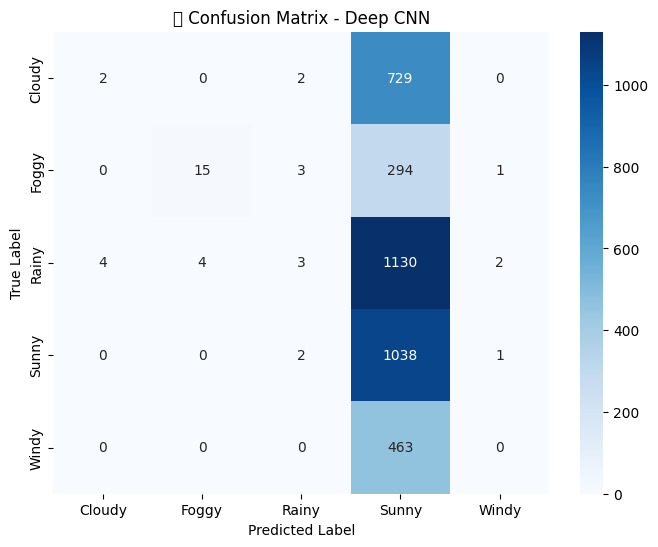

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('📊 Confusion Matrix - Deep CNN')
plt.show()


/tmp/ipython-input-515645768.py:28: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-515645768.py:28: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


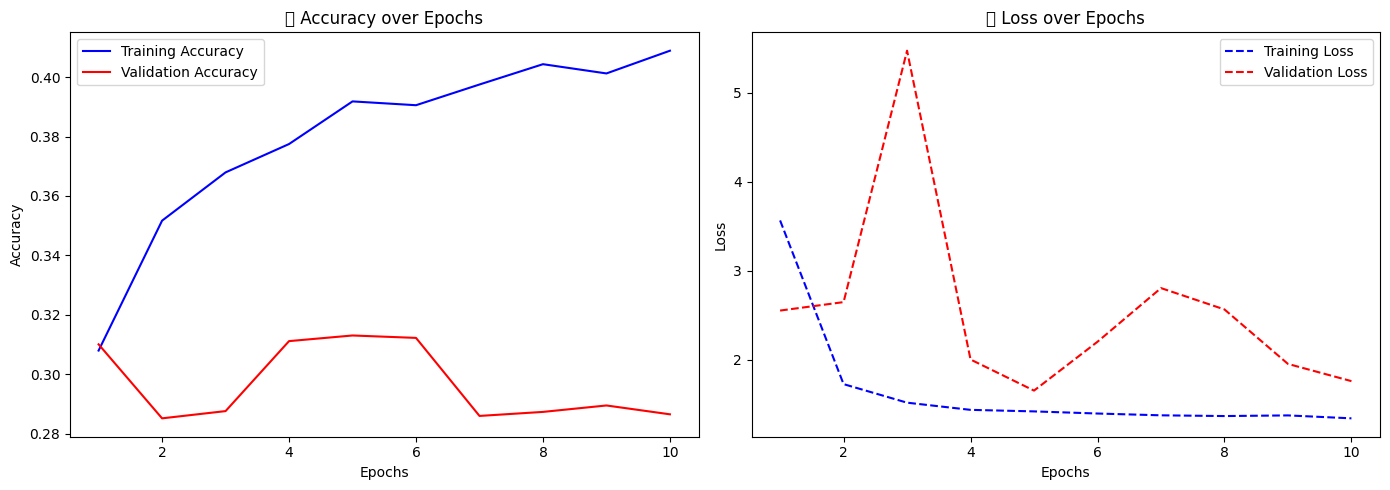

In [ ]:
def plot_cnn_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('🔵 Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b--', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('🔴 Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call it
plot_cnn_history(history)


In [ ]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Define output directory
output_dir = '/content/drive/MyDrive/AvianWeatherNet/results/deep_cnn'
os.makedirs(output_dir, exist_ok=True)

# === 1. Save the model ===
model.save(os.path.join(output_dir, 'deep_cnn_model.h5'))
print("✅ Model saved.")

# === 2. Save LabelEncoder ===
joblib.dump(le, os.path.join(output_dir, 'label_encoder.pkl'))
print("✅ Label encoder saved.")

# === 3. Save training plot (accuracy/loss) ===
def save_training_plot(history, save_path):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b--', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

save_training_plot(history, os.path.join(output_dir, 'training_plot.png'))
print("✅ Training plot saved.")

# === 4. Save classification report ===
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=le.classes_)
with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
    f.write(report)
print("✅ Classification report saved.")

# === 5. Save confusion matrix plot ===
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Deep CNN')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.close()
print("✅ Confusion matrix saved.")


✅ Model saved.
✅ Label encoder saved.
✅ Training plot saved.
116/116 ━━━━━━━━━━━━━━━━━━━━ 35s 298ms/step
✅ Classification report saved.
✅ Confusion matrix saved.


**CRNN**

In [ ]:
print("🔄 Reshaping data for CRNN input format...")

X_train_crnn = X_train.reshape(-1, 128, 128)
X_test_crnn = X_test.reshape(-1, 128, 128)

print(f"🧩 New shape: {X_train_crnn.shape} (samples, time steps, features)")


🔄 Reshaping data for CRNN input format...
🧩 New shape: (14772, 128, 128) (samples, time steps, features)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

print("🧠 Building CRNN model...")

model_crnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(128, 128)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    LSTM(128, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(y_train.shape[1], activation='softmax')
])

model_crnn.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

model_crnn.summary()


🧠 Building CRNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 63, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,293 (516.77 KB)

 Trainable params: 132,165 (516.27 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tqdm.keras import TqdmCallback
import time

print("🚀 Training CRNN...")

start_time = time.time()

history_crnn = model_crnn.fit(
    X_train_crnn, y_train,
    validation_data=(X_test_crnn, y_test),
    epochs=20,
    batch_size=32,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

print(f"✅ CRNN training completed in {round(time.time() - start_time, 2)} seconds.")


🚀 Training CRNN...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

✅ CRNN training completed in 1477.3 seconds.


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

print("📊 Evaluating CRNN model...")

y_pred_crnn = model_crnn.predict(X_test_crnn)
y_pred_classes = np.argmax(y_pred_crnn, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n📝 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


📊 Evaluating CRNN model...
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step

📝 Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.00      0.00      0.00       733
       Foggy       1.00      0.03      0.05       313
       Rainy       0.31      0.99      0.47      1143
       Sunny       0.23      0.01      0.02      1041
       Windy       0.00      0.00      0.00       463

    accuracy                           0.31      3693
   macro avg       0.31      0.21      0.11      3693
weighted avg       0.25      0.31      0.16      3693



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/tmp/ipython-input-2471364504.py:30: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2471364504.py:30: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


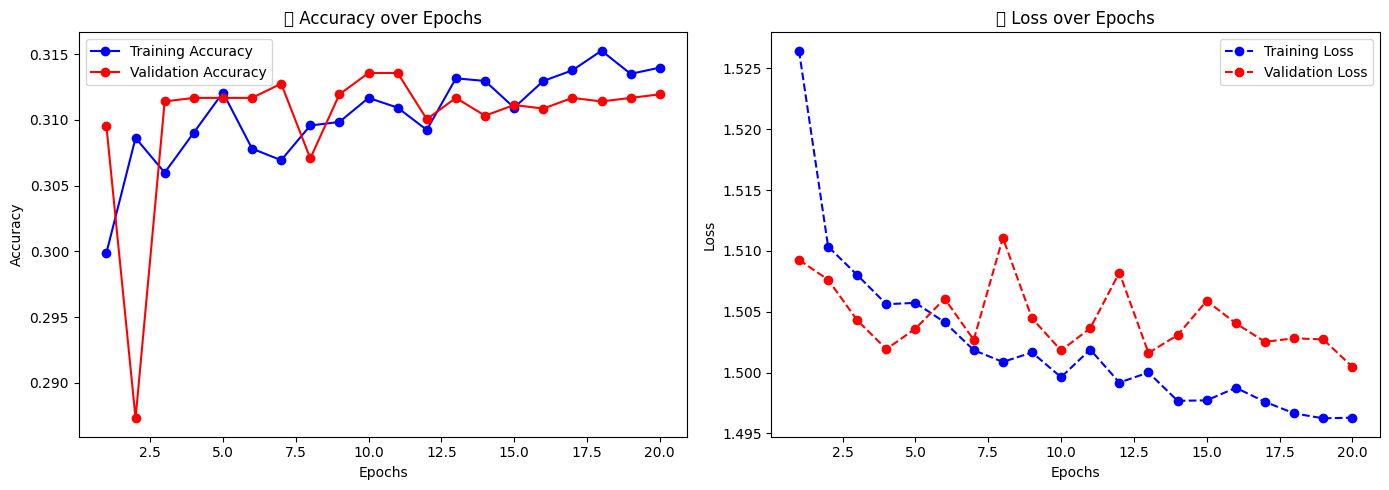

In [ ]:
import matplotlib.pyplot as plt

def plot_crnn_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('🔵 Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo--', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro--', label='Validation Loss')
    plt.title('🔴 Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_crnn_training(history_crnn)


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

print("📝 CRNN Classification Report:")

# Predict classes
y_pred_crnn = model_crnn.predict(X_test_crnn)
y_pred_classes_crnn = np.argmax(y_pred_crnn, axis=1)
y_true_classes_crnn = np.argmax(y_test, axis=1)

# Generate report
print(classification_report(y_true_classes_crnn, y_pred_classes_crnn, target_names=le.classes_))


📝 CRNN Classification Report:
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step
              precision    recall  f1-score   support

      Cloudy       0.00      0.00      0.00       733
       Foggy       1.00      0.03      0.05       313
       Rainy       0.31      0.99      0.47      1143
       Sunny       0.23      0.01      0.02      1041
       Windy       0.00      0.00      0.00       463

    accuracy                           0.31      3693
   macro avg       0.31      0.21      0.11      3693
weighted avg       0.25      0.31      0.16      3693



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


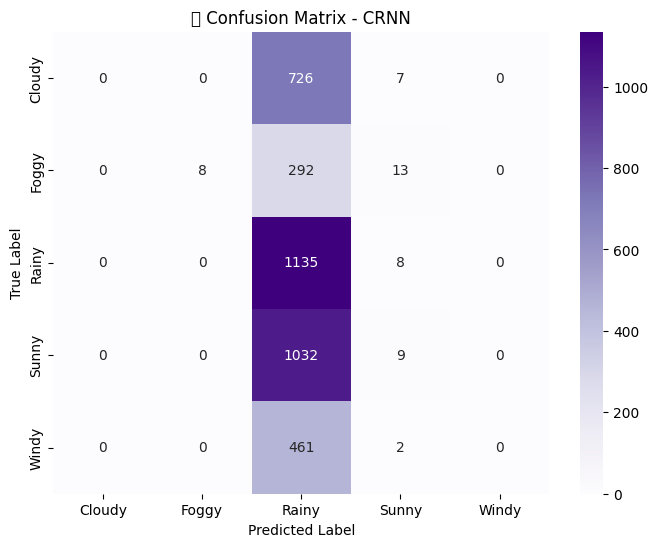

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm_crnn = confusion_matrix(y_true_classes_crnn, y_pred_classes_crnn)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_crnn, annot=True, fmt='d', cmap='Purples', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('📊 Confusion Matrix - CRNN')
plt.show()


In [ ]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# === 0. Set output directory ===
output_dir = '/content/drive/MyDrive/AvianWeatherNet/results/crnn'
os.makedirs(output_dir, exist_ok=True)

# === 1. Save the model ===
model_crnn.save(os.path.join(output_dir, 'crnn_model.h5'))
print("✅ CRNN model saved.")

# === 2. Save LabelEncoder ===
joblib.dump(le, os.path.join(output_dir, 'label_encoder.pkl'))
print("✅ Label encoder saved.")

# === 3. Save training plot (accuracy/loss) ===
def save_training_plot_crnn(history, save_path):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('CRNN Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b--', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('CRNN Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

save_training_plot_crnn(history_crnn, os.path.join(output_dir, 'training_plot.png'))
print("✅ Training plot saved.")

# === 4. Save classification report ===
y_pred_crnn = model_crnn.predict(X_test_crnn)
y_pred_classes_crnn = np.argmax(y_pred_crnn, axis=1)
y_true_classes_crnn = np.argmax(y_test, axis=1)

report_crnn = classification_report(
    y_true_classes_crnn,
    y_pred_classes_crnn,
    target_names=le.classes_
)

with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
    f.write(report_crnn)
print("✅ Classification report saved.")

# === 5. Save confusion matrix plot ===
cm_crnn = confusion_matrix(y_true_classes_crnn, y_pred_classes_crnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_crnn, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CRNN')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.close()
print("✅ Confusion matrix saved.")


✅ CRNN model saved.
✅ Label encoder saved.
✅ Training plot saved.
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step
✅ Classification report saved.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Confusion matrix saved.
